In [23]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

Word index goes in ---> Look-up table converts the index to the embedding vector for that word ---> hidden layer of neurons ---> tanh ---> softmax output of probability ---> maximize prob of true word in training
<center>
  <img src="Bengio_mlp.png" style="width: 100%;">
</center>

In [24]:
words = open('../makemore/names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [25]:
len(words)

32033

In [26]:
# build up the vocabulary and map to integer index
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [ ]:
# build the dataset

block_size = 3  # context, how many words you use to predict the next one
X, Y = [], []
for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)  # input
        Y.append(ix)  # correct prediction
        # print(''.join(itos[i] for i in context), '------>', itos[ix])
        # crop and append / slide context over by one
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [116]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [328]:
# build the dataset

import random


def build_dataset(words):
    block_size = 3  # context, how many words you use to predict the next one
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)  # input
            Y.append(ix)  # correct prediction
            # print(''.join(itos[i] for i in context), '------>', itos[ix])
            # crop and append / slide context over by one
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [329]:
print(n1, n2-n1, len(words)-n2)

25626 3203 3204


In [330]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [331]:
sum(p.nelement() for p in parameters)  # num total params

11897

In [332]:
for p in parameters:
    p.requires_grad = True

In [333]:
lrs = torch.logspace(-3, 0, 1000)

In [334]:
lri = []
lossi = []
stepi = []

In [335]:
for i in range(200_000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))  # 32 random rows

    # forward pass
    # (32, 3, 2) (nexamples, chars in context, dim of embedding space)
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1 if i < 100_000 else 0.01  # lrs[i]
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lr)
    stepi.append(i)
    lossi.append(loss.log10().item())


print(loss.item())

1.8860584497451782


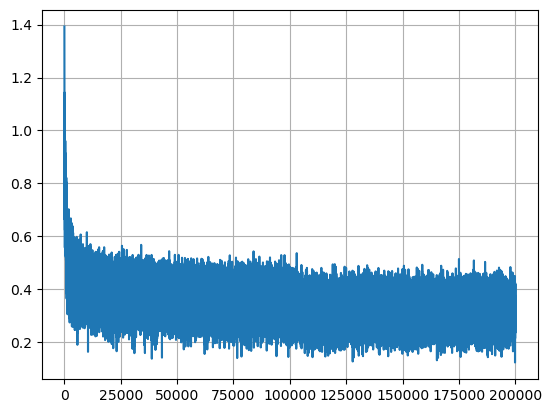

In [336]:
plt.plot(stepi, lossi)
plt.grid()

In [337]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.121729612350464


In [338]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.1788012981414795


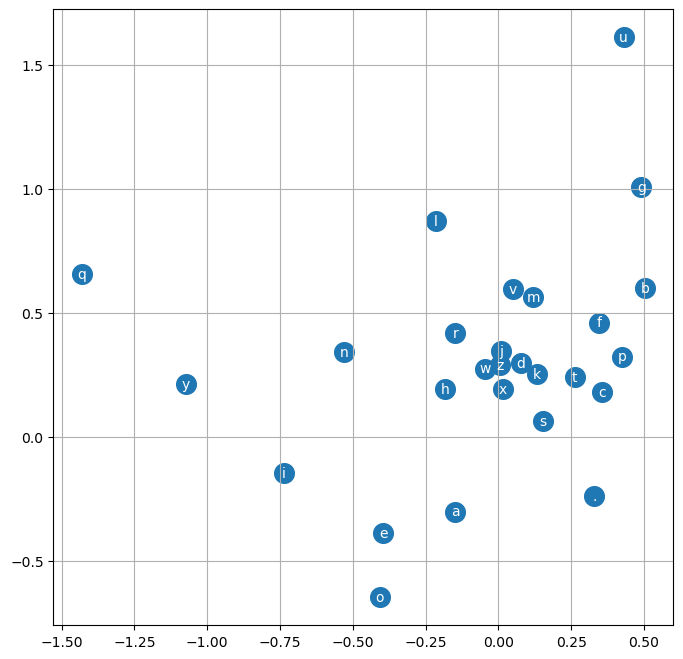

In [277]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i],
             ha='center', va='center', color='white')
plt.grid('minor')

In [ ]:
# Sampling from the model.
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]  # 1, block_size, d
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

mora.
mayah.
seel.
nico.
alarethan.
emerlee.
adelynnelin.
shi.
jen.
edellestanar.
katzion.
kalin.
shubprgahimiel.
kindrenlynn.
nochlanu.
zen.
dariyah.
fael.
yuma.
myston.


In [181]:
print(torch.log10(lrs[0]))

tensor(-3.)


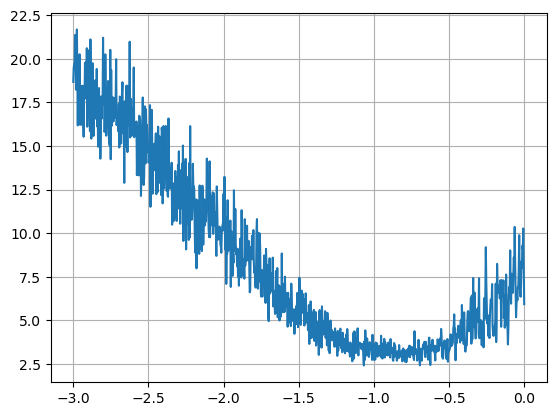

In [183]:
plt.plot(torch.log10(torch.tensor(lri)), lossi)
plt.grid()

2.5391719341278076


In [29]:
C = torch.randn((27, 2))

In [35]:
print(C[5])
print(C[[5, 6, 7, 7, 7]])
print(C[X].shape)

tensor([-0.4048, -1.6864])
tensor([[-0.4048, -1.6864],
        [ 1.4985, -0.8587],
        [ 0.7508,  0.0716],
        [ 0.7508,  0.0716],
        [ 0.7508,  0.0716]])
torch.Size([32, 3, 2])


In [32]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C == C[5]

tensor([True, True])

In [36]:
X[13, 2]

tensor(1)

In [37]:
print(C[X][13, 2])
print(C[1])  # why are they equal? Well X[13,2] = 1 and C[X]_ij does C[X[i,j]] so C[X]_13,2 = C[X[13,2]] = C[1] ok that's a little trippy

tensor([-1.3285,  0.4679])

In [54]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [60]:
# num inputs is 3 words x 2 dimensions per word vec c= 6, outputs is a hyperparameter we can set
W1 = torch.randn((6, 100))
b = torch.randn(100)

In [63]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b)  # use -1 for pytorch to infer

In [64]:
h

tensor([[-0.1013,  0.8495,  0.6557,  ...,  0.7982,  0.5707, -0.6846],
        [ 0.7702,  0.9987,  0.2543,  ..., -0.9989, -0.5133, -0.9999],
        [-0.8391,  0.8303,  0.7103,  ...,  0.9904,  0.9989,  0.7900],
        ...,
        [ 0.8294,  0.9996,  0.1596,  ..., -0.9996,  0.4658, -0.9995],
        [-0.2252,  0.9831,  0.7603,  ..., -0.9917,  0.9437, -0.8975],
        [ 0.4042, -0.5742,  0.6924,  ..., -0.9978, -0.8672, -0.8952]])

In [65]:
print((emb.view(-1, 6) @ W1).shape)
print(b.shape)
# broadcasting will align on the right and copy where it's 1 or no dimension there
# ALWAYS CHECK!
# 32, 100
#  1, 100

torch.Size([32, 100])
torch.Size([100])


In [68]:
W2 = torch.randn((100, 27))
b2 = torch.rand(27)

In [69]:
logits = h @ W2 + b2

In [70]:
logits.shape

torch.Size([32, 27])

In [71]:
counts = logits.exp()

In [77]:
prob = counts / counts.sum(1, keepdim=True)

In [78]:
prob.shape

torch.Size([32, 27])

In [83]:
# check the prob of the right label given the input examples
-prob[torch.arange(32), Y].log().mean()

tensor(14.6974)

In [81]:
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [56]:
emb.view(32, 6) == torch.cat(torch.unbind(emb, dim=1), dim=1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [39]:
# num inputs is 3 words x 2 dimensions per word vec c= 6, outputs is a hyperparameter we can set
W1 = torch.randn((6, 100))
b = torch.randn(100)

In [44]:
# 32x3x2 --> 32x6
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]],
          dim=1).shape  # concatenate 3 words together

torch.Size([32, 6])

In [48]:
# better/extendable way of previous cell
torch.cat(torch.unbind(emb, dim=1), dim=1).shape

torch.Size([32, 6])

In [51]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [52]:
a.view(3, 2, 3)

tensor([[[ 0,  1,  2],
         [ 3,  4,  5]],

        [[ 6,  7,  8],
         [ 9, 10, 11]],

        [[12, 13, 14],
         [15, 16, 17]]])

In [53]:
a.storage()

/tmp/ipykernel_12336/214256462.py:1: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  a.storage()


 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]